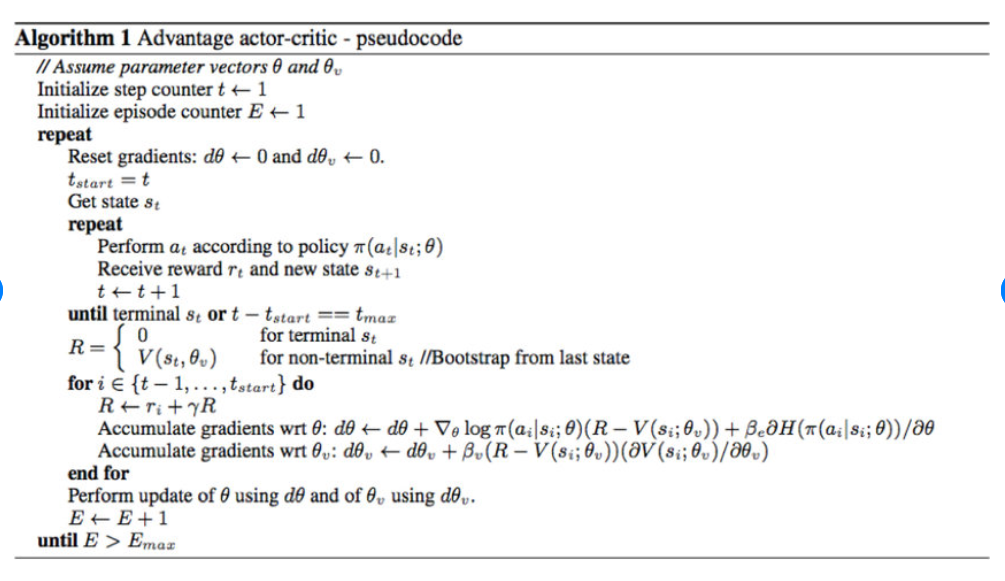

In [22]:
from machine import Machine
from GymMachEnv import MachineEnv
from datetime import datetime
import numpy as np

# Code from scratch

reference: https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py

# Verify

In [3]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# machine = Machine()
# machine.curr_state = 0
# env = MachineEnv(machine)

# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n
# lr = 0.0001

env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 1)


    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.9):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


def trainIters(actor, critic, n_iters):
    optimizerA = optim.Adam(actor.parameters())
    optimizerC = optim.Adam(critic.parameters())
    score_list = []
    for iter in range(n_iters): #episode loop
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        for i in count(): #number of steps is equivalent to number of rewards

            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state

            if done:
                print("\rIteration: {}, Score: {}".format(iter, i), end="")
                score_list.append(i)
                break

        
        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)  #Q value
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    torch.save(actor, 'cart_actor.pkl')
    torch.save(critic, 'cart_critic.pkl')
    env.close()
    return score_list

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

def plot(score):
    df = pd.DataFrame(score)
    moving_ave = df.iloc[:,1].rolling(10,min_periods=1).mean().values.flatten().tolist()

    ep = [i for i in range(len(score))]
    fig = plt.figure(figsize=(10,10))
    plt.plot(ep,score,label = 'Episodic Reward')
    plt.plot(ep,moving_ave,label = f'Moving Average Window {10}')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

In [ ]:
ac = Actor(state_size,action_size)
critic = Critic(state_size,action_size)
score = trainIters(ac,critic,300)

In [ ]:
x = torch.FloatTensor(env.reset())

In [ ]:
ac = torch.load('cart_actor.pkl')
y = ac(x).sample()
y.tolist()

In [ ]:
plot(score)

# Implementation

In [ ]:
def trainItersMachine(actor, critic, n_iters,env,timesteps = None):
    optimizerA = optim.Adam(actor.parameters(),lr=0.0001)
    optimizerC = optim.Adam(critic.parameters(),lr=0.0001)
    score_list = []
    steps_score = []
    steps = 0
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        done = False

        while done == False: #number of steps is equivalent to number of rewards, take full episode
            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state
            steps+=1
            
            if steps%1000 and len(score_list)!= 0:
                steps_score.append(sum(score_list)/len(score_list))
            
            if done:
                print("\rIteration: {}, Score: {}, Steps: {}".format(iter, sum(rewards), steps),end="")
                score_list.append(sum(rewards))
                break


        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    torch.save(actor, 'actor.pt')
    torch.save(critic, 'critic.pt')
    env.close()
    return [score_list,steps_score]

In [ ]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

ac2 = Actor(state_size,action_size)
critic2 = Critic(state_size,action_size)
scoreMach = trainItersMachine(ac2,critic2,10000,env)


In [ ]:
plot(scoreMach[0])

In [ ]:
sum(scoreMach)/len(scoreMach)

# Using Baseline API

In [ ]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import CheckpointCallback
from stable_baselines.common.callbacks import EvalCallback
import gym
import tensorflow as tf

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv
machine = Machine()
machine.curr_state = 0
env = DummyVecEnv([lambda: MachineEnv(machine)])

machine2 = Machine()
machine2.curr_state = 0
eval_env = DummyVecEnv([lambda: MachineEnv(machine2)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./best/',
                             log_path='./best/', eval_freq=500,
                             deterministic=True, render=False)

policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[128, 256])


model = A2C('MlpPolicy',env,verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/",policy_kwargs= policy_kwargs).learn(total_timesteps=50000,callback=eval_callback)

In [ ]:
model.get_parameters()

In [ ]:
model.save("trained")

In [ ]:
obs = env.reset()
for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(action,rewards)

In [ ]:
env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

model = A2C('MlpPolicy', 'CartPole-v1', verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/")
model.learn(total_timesteps=10000)

# Optuna

In [6]:
import optuna

In [15]:
def generate_layers_actor(layers,state_dim,action_dim):
    ac_layer = []
        
    for i in range(len(layers)-1):
        if i == 0:
            ac_layer.append(nn.Linear(state_dim,layers[i]))
            ac_layer.append(nn.ReLU())
            
        ac_layer.append(nn.Linear(layers[i],layers[i+1]))
        ac_layer.append(nn.ReLU())
        
    ac_layer.append(nn.Linear(layers[-1],action_dim))
    ac_layer.append(nn.Softmax(dim=-1))
    
    return ac_layer

def generate_layers_critic(layers,state_dim):
    cc_layer = []
        
    for i in range(len(layers)-1):
        if i == 0:
            cc_layer.append(nn.Linear(state_dim,layers[i]))
            cc_layer.append(nn.ReLU())
            
        cc_layer.append(nn.Linear(layers[i],layers[i+1]))
        cc_layer.append(nn.ReLU())
        
    cc_layer.append(nn.Linear(layers[-1],1))
    
    return cc_layer


class Custom_Actor(nn.Module):
    def __init__(self, state_size, action_size,layers):
        super(Custom_Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        actor_layers = generate_layers_actor(layers,state_size,action_size)
        self.actor = nn.Sequential(*actor_layers)
        

    def forward(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        return dist


class Custom_Critic(nn.Module):
    def __init__(self, state_size, action_size,layers):
        super(Custom_Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        critic_layers = generate_layers_critic(layers,state_size)
        self.critic = nn.Sequential(*critic_layers)


    def forward(self, state):
        value =  self.critic(state)
        return value
    
def Custom_trainItersMachine(actor, critic, n_iters,env,params):
    optimizerA=getattr(torch.optim,params['optimizer'])(actor.parameters(),lr=params['actor_lr'])
    optimizerC = getattr(torch.optim,params['optimizer'])(critic.parameters(),lr=params['critic_lr'])
    score_list = []

    steps = 0
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        done = False

        while done == False: #number of steps is equivalent to number of rewards, take full episode
            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state
            steps+=1
            
            if done:
                #print("\rIteration: {}, Score: {}, Steps: {}".format(iter, sum(rewards), steps),end="")
                score_list.append(sum(rewards))
                break


        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks,params['gamma'])

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    return np.mean(np.array(score_list)[-50:])

In [19]:
def objective(trial):
    max_episodes = 10000  #Each trial is 1000 episodes
    state_size = 4
    action_size = 2
    
    num_layers = trial.suggest_int('num_layers', 2, 5)
    
    layers = []
    for i in range(num_layers):
        n_units = int(trial.suggest_loguniform('n_units_l{}'.format(i), 32, 256))
        layers.append(n_units)
    
    params = {
                'actor_lr': trial.suggest_loguniform('learning_rate_actor', 1e-5, 2e-3),
                'critic_lr': trial.suggest_loguniform('learning_rate_critic', 1e-5, 2e-3),
                'layers':layers,
                'gamma':trial.suggest_uniform('gamma',0.85,0.99),
                'optimizer':trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    machine = Machine()
    machine.curr_state = 0
    env = MachineEnv(machine)

    ac2 = Custom_Actor(state_size,action_size,layers)
    critic2 = Custom_Critic(state_size,action_size,layers)
    scoreMach = Custom_trainItersMachine(ac2,critic2,max_episodes,env,params)
    
    return scoreMach

In [20]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(),pruner = optuna.pruners.SuccessiveHalvingPruner())

[I 2022-01-26 21:23:10,452] A new study created in memory with name: no-name-313cec5c-d959-40f6-ada0-f6ae965b528e


In [23]:
start_time = datetime.now().replace(microsecond=0)
study.optimize(objective, n_trials=30)
end_time = datetime.now().replace(microsecond=0)
print("Total training time  : ", end_time - start_time)

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
[I 2022-01-26 23:01:53,007] Trial 1 finished with value: 25104.0 and parameters: {'num_layers': 3, 'n_units_l0': 70.1586704691615, 'n_units_l1': 211.720487991093, 'n_units_l2': 40.43972680188564, 'learning_rate_actor': 2.920689130393376e-05, 'learning_rate_critic': 0.0003393938138009275, 'gamma': 0.9388956059562317, 'optimizer': 'Adam'}. Best is trial 1 with value: 25104.0.
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
[I 2022-01-26 23:34:28,417] Trial 2 finished with value: 21070.0 and parameters: 

ValueError: Expected parameter probs (Tensor of shape (2,)) of distribution Categorical(probs: torch.Size([2])) to satisfy the constraint Simplex(), but found invalid values:
tensor([nan, nan], grad_fn=<DivBackward0>)

In [32]:
def train_and_evaluate_test(actor, critic, n_iters,env,params):
    
    optimizerA=getattr(torch.optim,params['optimizer'])(actor.parameters(),lr=params['actor_lr'])
    optimizerC = getattr(torch.optim,params['optimizer'])(critic.parameters(),lr=params['critic_lr'])
    score_list = []

    steps = 0
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        done = False

        while done == False: #number of steps is equivalent to number of rewards, take full episode
            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state
            steps+=1
            
            if done:
                #print("\rIteration: {}, Score: {}, Steps: {}".format(iter, sum(rewards), steps),end="")
                score_list.append([iter,sum(rewards)])
                break


        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks,params['gamma'])

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()

    return score_list

In [33]:
best_params = {'num_layers': 3, 
               'n_units_l0': 70.1586704691615, 
               'n_units_l1': 211.720487991093, 
               'n_units_l2': 40.43972680188564, 
               'actor_lr': 2.920689130393376e-05, 
               'critic_lr': 0.0003393938138009275, 
               'gamma': 0.9388956059562317, 
               'optimizer': 'Adam'}

best_layers = [70,211,40]
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

ac2_best = Custom_Actor(state_size,action_size,best_layers)
critic2_best = Custom_Critic(state_size,action_size,best_layers)
scoreMach_best = train_and_evaluate_test(ac2_best,critic2_best,10000,env,best_params)

In [43]:
scoreMach_best = [[x[0],float(x[1])] for x in scoreMach_best]


In [44]:
scoreMach_best

[[0, 32300.0],
 [1, 400.0],
 [2, 22400.0],
 [3, 500.0],
 [4, 44000.0],
 [5, 2500.0],
 [6, 41100.0],
 [7, 10200.0],
 [8, 42500.0],
 [9, 36700.0],
 [10, 35500.0],
 [11, 48600.0],
 [12, 47000.0],
 [13, 12700.0],
 [14, 11500.0],
 [15, 8000.0],
 [16, 2400.0],
 [17, 20400.0],
 [18, 3500.0],
 [19, 34800.0],
 [20, 52600.0],
 [21, 38800.0],
 [22, 1400.0],
 [23, 6700.0],
 [24, 44000.0],
 [25, 12400.0],
 [26, 24200.0],
 [27, 12800.0],
 [28, 25200.0],
 [29, 1100.0],
 [30, 41100.0],
 [31, 14700.0],
 [32, 47000.0],
 [33, 4000.0],
 [34, 2700.0],
 [35, 7200.0],
 [36, 21200.0],
 [37, 1800.0],
 [38, 40400.0],
 [39, 20800.0],
 [40, 15600.0],
 [41, 23600.0],
 [42, 35600.0],
 [43, 1500.0],
 [44, 18500.0],
 [45, 7800.0],
 [46, 8500.0],
 [47, 49600.0],
 [48, 13200.0],
 [49, 10300.0],
 [50, 2200.0],
 [51, 31300.0],
 [52, 50700.0],
 [53, 26000.0],
 [54, 38900.0],
 [55, 24300.0],
 [56, 21300.0],
 [57, 1900.0],
 [58, 49200.0],
 [59, 11000.0],
 [60, 38300.0],
 [61, -1000.0],
 [62, 19700.0],
 [63, 7000.0],
 [64, 2

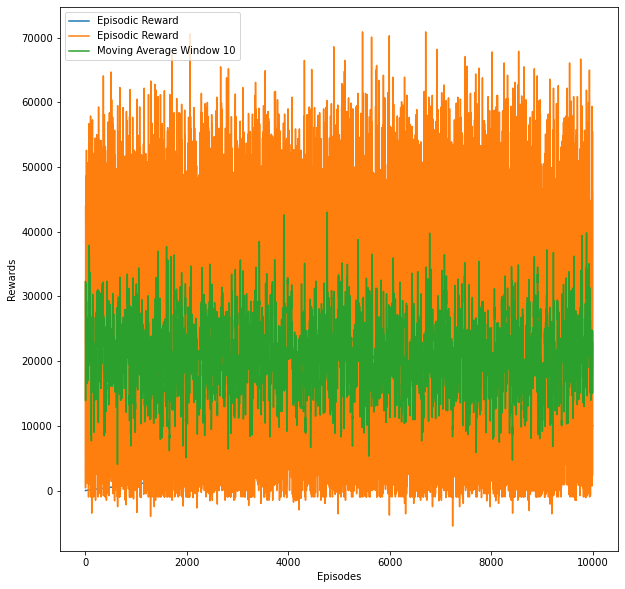

In [47]:
plot(scoreMach_best)